In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import xarray as xr

from typing import Sequence, Optional, Union

import torch
print(torch.__version__)
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal

from collections import namedtuple

import torchsde

#for plotting
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

2.1.2+cpu


# ERA5 Data: Temperature (t), Wind Speed (ws), Geopotential (z) at 1000hPa height

c:\Users\Anwender\.conda\envs\rivapy\lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


Text(0.5, 1.0, 'Timeseries of geopotential [m^2/s^2]')

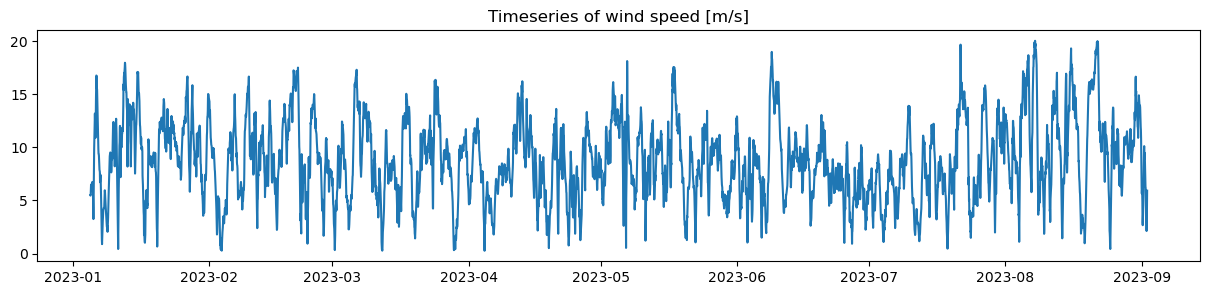

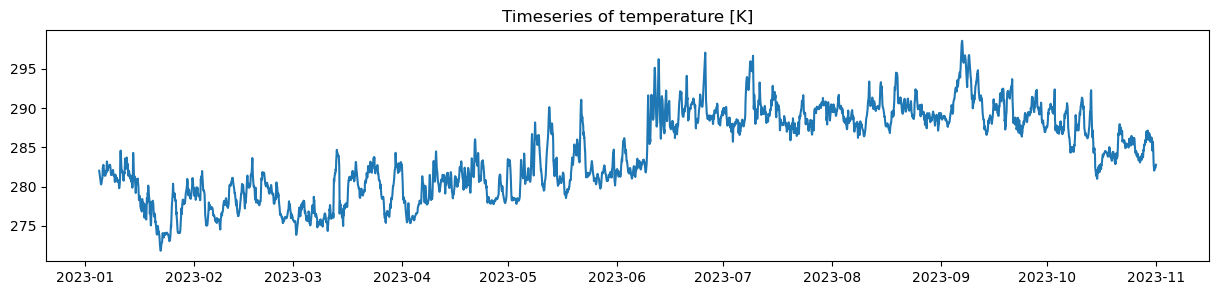

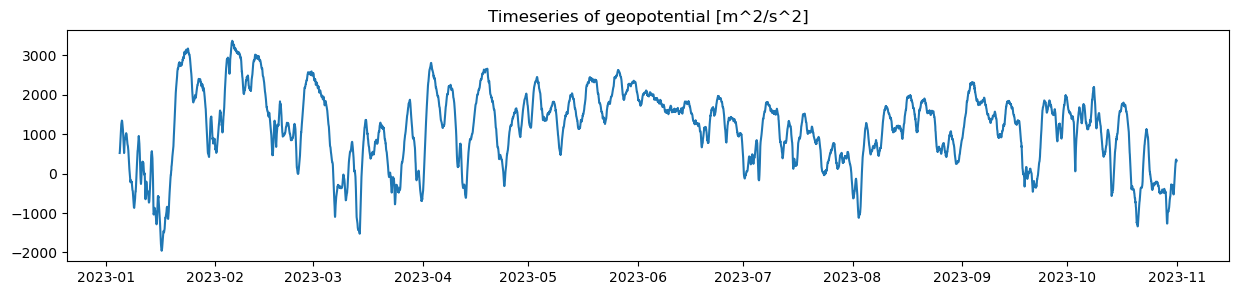

In [2]:
ft = xr.open_dataset('dataset_T_2023_1000hPa.nc')
t100 = ft.variables['t'][:,:,:] # temperature
t100_data = np.array(t100)


fgp = xr.open_dataset('dataset_GP_2023_1000hPa.nc')
z100 = fgp.variables['z'][:,:,:] # geopotential
z100_data = np.array(z100)


f = xr.open_dataset('dataset_2012-2023_1000hPa.nc')
lons = f.variables['longitude'][:]  # longitude
lats = f.variables['latitude'][:]  # latitude
u100 = f.variables['u'][:,:,:,0] # u-wind 
v100 = f.variables['v'][:,:,:,0]  # v-wind 
time = f.variables['time'][:] # time


ws100_data = np.array(np.sqrt(u100*u100+v100*v100)) #wind speed


nan_idx = np.argwhere(~np.isnan(ws100_data[:,0,0])).T[0]
ws100 = ws100_data[nan_idx,:,:]
time_vec = time[nan_idx]


plt.figure(figsize = (15,3))
plt.plot(time_vec[-24*300:],ws100_data[-24*300:,2,2])
plt.title('Timeseries of wind speed [m/s]')

plt.figure(figsize = (15,3))
plt.plot(time_vec[-24*300:],t100_data[-24*300:,2,2])
plt.title('Timeseries of temperature [K]')

plt.figure(figsize = (15,3))
plt.plot(time_vec[-24*300:],z100_data[-24*300:,2,2])
plt.title('Timeseries of geopotential [m^2/s^2]')





In [3]:
ws_ly = ws100[-24*301:,:,:]
t_ly = t100_data[-24*301:,:,:]
z_ly = z100_data[-24*301:,:,:]

# Neural SDE for historical weather data based on Scaleable Gradients for SDEs by Li et al. (2020)

https://blog.keras.io/building-autoencoders-in-keras.html
Variational autoencoder (VAE)
Variational autoencoders are a slightly more modern and interesting take on autoencoding.

What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon ( z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)) , where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

Because a VAE is a more complex example, we have made the code available on Github as a standalone script. Here we will review step by step how the model is created.

In [4]:

class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val


#Encoder 
# https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
# here's our encoder network, mapping inputs to our latent distribution parameters
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.gru =nn.Linear(input_size, hidden_size) #FS nn.GRU(input_size=input_size, hidden_size=hidden_size)
        self.softplus = nn.Softplus()
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        out = self.gru(inp)
        out = self.softplus(out)
        out = self.lin(out)
        return out



class LatentSDE(nn.Module):
    # stochastic ito integral
    sde_type = "ito"
    # diffusion is element wise 
    noise_type = "diagonal" 

    def __init__(self, data_size, latent_size, context_size, hidden_size): # decoder_hiddensiz
        super(LatentSDE, self).__init__()
        # Encoder.
        self.encoder = Encoder(input_size=data_size, hidden_size=hidden_size, output_size=context_size)
        self.qz0_net = nn.Linear(context_size, latent_size + latent_size)

        # Decoder.
        # corresponding (posterior) drift
        self.f_net = nn.Sequential(
            nn.Linear(latent_size + context_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        # corresponding to prior drift to calculate KL divergence (section 5 in Scalable Gradients for SDEs by Li et al., 2020) to reduce overfitting
        self.h_net = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        # Diffusion: This needs to be an element-wise function for the SDE to satisfy diagonal noise.
        self.g_nets = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(1, hidden_size),
                    nn.Softplus(),
                    nn.Linear(hidden_size, 1),
                    nn.Sigmoid()
                )
                for _ in range(latent_size)
            ]
        )
        #self.projector = nn.Linear(latent_size, data_size)
        #Decoder: 
        self.projector =nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, data_size),
        )
        self.pz0_mean = nn.Parameter(torch.zeros(1, latent_size))
        self.pz0_logstd = nn.Parameter(torch.zeros(1, latent_size))

        self._ctx = None

    def contextualize(self, ctx):
        self._ctx = ctx  

    def f(self, t, y): # (posterior) Drift 
        ts, ctx = self._ctx
        i = min(torch.searchsorted(ts, t, right=True), len(ts) - 1)
        return self.f_net(torch.cat((y, ctx[i]), dim=1))

    def h(self, t, y): # (prior) Drift
        return self.h_net(y)

    def g(self, t, y):  # Diagonal diffusion.
        y = torch.split(y, split_size_or_sections=1, dim=1)
        out = [g_net_i(y_i) for (g_net_i, y_i) in zip(self.g_nets, y)]
        return torch.cat(out, dim=1)

    def forward(self, xs, ts, noise_std, adjoint=False, method="midpoint"):
        ctx = self.encoder(torch.flip(xs, dims=(0,)))
        ctx = torch.flip(ctx, dims=(0,))
        self.contextualize((ts, ctx))

        qz0_mean, qz0_logstd = self.qz0_net(ctx[0]).chunk(chunks=2, dim=1)
        z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)

        if adjoint:
            # Must use the argument `adjoint_params`, since `ctx` is not part of the input to `f`, `g`, and `h`.
            adjoint_params = (
                    (ctx,) +
                    tuple(self.f_net.parameters()) + tuple(self.g_nets.parameters()) + tuple(self.h_net.parameters())
            )
            zs, log_ratio = torchsde.sdeint_adjoint(
                self, z0, ts, adjoint_params=adjoint_params, dt=1, logqp=True, method=method)
        else:
            zs, log_ratio = torchsde.sdeint(self, z0, ts, dt=1, logqp=True, method=method)

        _xs = self.projector(zs)
        xs_dist = Normal(loc=_xs, scale=noise_std)
        log_pxs = xs_dist.log_prob(xs).sum(dim=(0, 2)).mean(dim=0)

        qz0 = torch.distributions.Normal(loc=qz0_mean, scale=qz0_logstd.exp())
        pz0 = torch.distributions.Normal(loc=self.pz0_mean, scale=self.pz0_logstd.exp())
        logqp0 = torch.distributions.kl_divergence(qz0, pz0).sum(dim=1).mean(dim=0)
        logqp_path = log_ratio.sum(dim=0).mean(dim=0)
        return log_pxs, logqp0 + logqp_path

    #We can use these parameters to sample new similar points from the latent space
    @torch.no_grad()
    def sample(self, batch_size, ts, bm=None):
        eps = torch.randn(size=(batch_size, *self.pz0_mean.shape[1:]), device=self.pz0_mean.device)
        z0 = self.pz0_mean + self.pz0_logstd.exp() * eps
        print(z0)
        print(z0.size())
        print(z0.dtype)
        print(self.pz0_mean)
        zs = torchsde.sdeint(self, z0, ts, names={'drift': 'h'}, dt=1, bm=bm)
        # Most of the times in ML, we don't sample the observation noise for visualization purposes.
        _xs = self.projector(zs)
        return _xs



In [5]:
# Parameters
batch_size=16#512#1024
latent_size=8
context_size=16
hidden_size=16#2#128
lr_init=1e-2
t0=0.
t1=25.
lr_gamma=0.997
kl_anneal_iters=1000
pause_every=1
noise_std=0.1
adjoint=False
train_dir='./'
method="milstein"

num_samples=batch_size

In [6]:
device = torch.device('cpu')

In [7]:
xs = torch.empty((int(t1), batch_size, 1), dtype=torch.float32)
ts = torch.empty(int(t1), dtype=torch.float32)
x0 = torch.empty((batch_size, latent_size), dtype=torch.float32)

In [8]:
# select some coordinates and short range from time series
xcoord = 16
ycoord = 1

ws_mean = np.mean(ws_ly[int(t1),0:xcoord,:ycoord])
ws_std = np.std(ws_ly[int(t1),0:xcoord,:ycoord])
t_mean = np.mean(t_ly[int(t1),0:xcoord,:ycoord])
t_std = np.std(t_ly[int(t1),0:xcoord,:ycoord])
z_mean = np.mean(z_ly[int(t1),0:xcoord,:ycoord])
z_std = np.std(z_ly[int(t1),0:xcoord,:ycoord])

ws_ly = (ws_ly-ws_mean)/ws_std
t_ly = (t_ly-t_mean)/t_std
z_ly = (z_ly-z_mean)/z_std

ws_test = torch.tensor(ws_ly[21:21+int(t1),0:xcoord,:ycoord])
temp_test = torch.tensor(t_ly[21:21+int(t1),0:xcoord,:ycoord])
gp_test = torch.tensor(t_ly[21:21+int(t1),0:xcoord,:ycoord])



for i in range(25):
    ts[i] = float(i)
    for j in range(xcoord):
        for k in range(ycoord):
            #plt.plot(temp_test[0:25,j,k])
            xs[i,j+k,0] = ws_test[i,j,k]
            #xs[i,j+k,1] = temp_test[i,j,k]
            #xs[i,j+k,2] = gp_test[i,j,k]



In [9]:

latent_sde = LatentSDE(
        data_size=1,
        latent_size=latent_size,
        context_size=context_size,
        hidden_size=hidden_size,
    ).to(device)

optimizer = optim.Adam(params=latent_sde.parameters(), lr=lr_init)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer)#ExponentialLR(optimizer=optimizer, gamma=lr_gamma)
kl_scheduler = LinearScheduler(iters=kl_anneal_iters)

# Fix the same Brownian motion for visualization.
bm_vis = torchsde.BrownianInterval(
        t0=t0, t1=t1, size=(batch_size, latent_size,), device=device, levy_area_approximation="space-time")

In [10]:
num_iters = 100
for global_step in tqdm.tqdm(range(1, num_iters + 1)):
    latent_sde.zero_grad()
    log_pxs, log_ratio = latent_sde(xs, ts, noise_std, adjoint, method)
    loss = -log_pxs + log_ratio * kl_scheduler.val
    #print(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()
    kl_scheduler.step()





    

100%|██████████| 100/100 [00:09<00:00, 10.44it/s]


tensor([[-0.3144,  1.9207, -1.3912,  1.8990, -3.0264,  0.6177,  2.0515, -1.9284],
        [ 0.9768, -0.3006, -1.6392,  0.9057,  5.9889, -0.1759, -0.6607,  0.3997],
        [ 1.4771,  2.6350, -0.3349,  5.3986, -1.1895,  0.2652,  5.2046,  2.4151],
        [ 1.4221,  2.3164,  1.7585,  2.8600,  2.1271,  0.5854,  2.2646,  2.0374],
        [ 1.6901, -1.6655, -4.6392, -3.2233,  4.0765,  0.0726, -4.2871,  5.4352],
        [ 1.3522,  0.4831, -0.5399,  1.3008,  1.1414,  0.3359, -0.1622, -1.4290],
        [ 0.2064,  1.3615, -4.9260,  1.6390, -3.7367, -0.3369,  3.4501, -1.2560],
        [ 0.5174,  0.5866,  2.9803, -2.1639, -6.8522, -0.0726,  4.3028,  4.2803],
        [ 1.4067,  2.5486, -0.2369,  0.9746,  0.2288,  0.3720,  2.0721,  4.1365],
        [ 1.2728,  0.0919, -3.7643, -0.3986,  0.0975,  0.1056, -2.2423,  0.1246],
        [ 0.0892,  4.3634,  2.5390,  0.8371, -0.1405, -0.0501,  4.4103,  2.3288],
        [-0.5946,  2.7561,  1.7734,  0.1342, -1.0945,  0.5259,  1.9134,  4.0998],
        [ 1.1729

TypeError: list indices must be integers or slices, not tuple

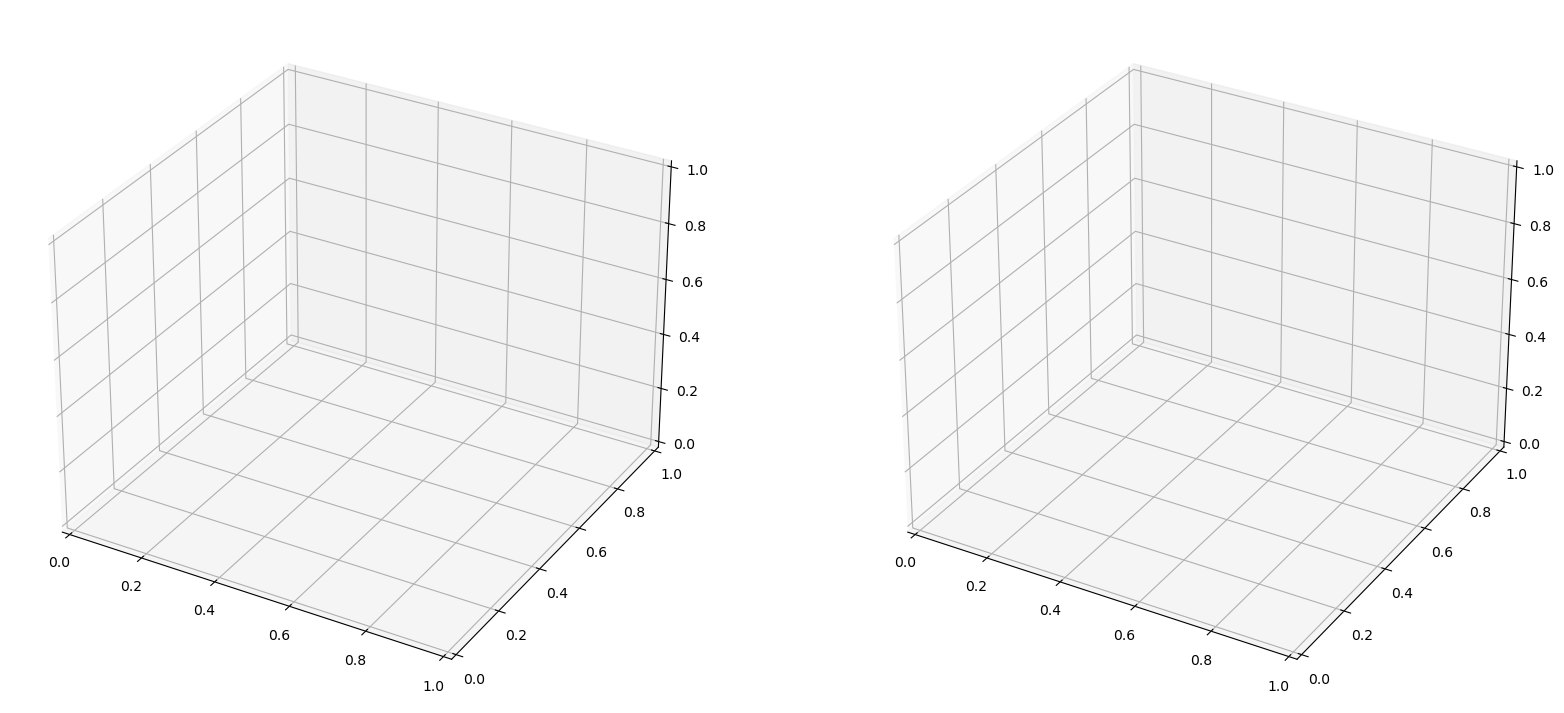

In [15]:
xs_l = latent_sde.sample(batch_size=xs.size(1), ts=ts, bm=bm_vis)

fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(1, 2)
ax00 = fig.add_subplot(gs[0, 0], projection='3d')
ax01 = fig.add_subplot(gs[0, 1], projection='3d')


# Left plot: data.
z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax00.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
ax00.set_xlabel('$norm. price$', labelpad=0., fontsize=16)
ax00.set_ylabel('$norm. demand$', labelpad=.5, fontsize=16)
ax00.set_zlabel('$norm. wind$', labelpad=0., horizontalalignment='center', fontsize=16)
ax00.set_title('Data', fontsize=20)
xlim = ax00.get_xlim()
#ylim = ax00.get_ylim()
#zlim = ax00.get_zlim()

# Right plot: model.
z1, z2, z3 = np.split(xs_l.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax01.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
ax00.set_xlabel('$norm. price$', labelpad=0., fontsize=16)
ax00.set_ylabel('$norm. demand$', labelpad=.5, fontsize=16)
ax00.set_zlabel('$norm. wind$', labelpad=0., horizontalalignment='center', fontsize=16)
ax01.set_title('Samples', fontsize=20)
ax01.set_xlim(xlim)
#ax01.set_ylim(ylim)
#ax01.set_zlim(zlim)

plt.show()